# Task 2: Chunking, Embedding, and Indexing 🧩

This notebook covers the RAG pipeline construction: chunking the text, embedding it, and indexing it into a Vector Database (ChromaDB).

## Objectives
1. **Load Preprocessed Data**: Use the cleaned data from Task 1.
2. **Chunking**: Split narratives into manageable chunks with overlap.
3. **Embedding**: Convert chunks into vector embeddings using `all-MiniLM-L6-v2`.
4. **Vector Store**: Index these embeddings into a local ChromaDB instance.

In [1]:
import sys
import os
import pandas as pd

# Add src to path
sys.path.append(os.path.abspath(os.path.join('../src')))
from chunk_embed_index import ChunkEmbedIndex

## 1. Initialize Pipeline
We initialize the `ChunkEmbedIndex` class pointing to our processed data and target vector store location.

In [2]:
DATA_PATH = '../data/processed/cleaned_complaints.csv'
VECTOR_DB_PATH = '../vector_store'
COLLECTION_NAME = 'complaints_prototype'

indexer = ChunkEmbedIndex(DATA_PATH, VECTOR_DB_PATH, COLLECTION_NAME)

## 2. Load Data with Stratified Sampling

### Sampling Strategy
The dataset contains 248K+ complaints across 4 products with significant class imbalance:
- **Savings account**: 140K (56%)
- **Credit card**: 81K (32%)  
- **Personal loan**: 26K (11%)
- **Money transfers**: 1.5K (1%)

To ensure all products are represented in the sample, **stratified sampling** is used. This approach:
- Samples proportionally from each product category
- Preserves the original class distribution
- Ensures rare products (Money transfers) are not excluded

For a 15K sample:
- Savings: ~8,400 rows (56%)
- Credit card: ~4,800 rows (32%)
- Personal loan: ~1,650 rows (11%)
- Money transfers: ~150 rows (1%)

This prevents training/indexing bias and ensures the RAG system can retrieve relevant complaints for all product types.

In [3]:
# Load 15K rows with stratified sampling
indexer.load_processed_data(nrows=15000, stratified=True)

Loading data from ../data/processed/cleaned_complaints.csv...
Using stratified sampling to load 15000 rows...

Total available rows: 248617
Product distribution in full dataset:
Product
Savings account    140319
Credit card         80667
Personal loan       26134
Money transfers      1497
Name: count, dtype: int64

Sampling strategy:
  Savings account: 8465 rows
  Credit card: 4866 rows
  Personal loan: 1576 rows
  Money transfers: 90 rows

✓ Loaded 14996 rows.

Total available rows: 248617
Product distribution in full dataset:
Product
Savings account    140319
Credit card         80667
Personal loan       26134
Money transfers      1497
Name: count, dtype: int64

Sampling strategy:
  Savings account: 8465 rows
  Credit card: 4866 rows
  Personal loan: 1576 rows
  Money transfers: 90 rows

✓ Loaded 14996 rows.


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Product_Original,cleaned_narrative
0,2021-06-08,Personal loan,Installment loan,Problem when making payments,NaN,So my husband and I both got a loan in XXXX of...,Company disputes the facts presented in the co...,"Atlas Credit Company, Inc.",TX,75002,NaN,Consent provided,Web,2021-06-09,Closed with explanation,Yes,NaN,4442262,"Payday loan, title loan, or personal loan",husband got loan 2020 made couple payment sudd...
1,2025-01-29,Savings account,Checking account,Problem caused by your funds being low,Overdrafts and overdraft fees,I am writing to file a complaint against Navy ...,Company believes it acted appropriately as aut...,NAVY FEDERAL CREDIT UNION,NC,283XX,NaN,Consent provided,Web,2025-01-29,Closed with explanation,Yes,NaN,11834712,Checking or savings account,navy federal credit union regarding multiple o...
2,2015-06-23,Credit card,NaN,Unsolicited issuance of credit card,NaN,Bank of America sent me a pre-approved credit ...,Company chooses not to provide a public response,"BANK OF AMERICA, NATIONAL ASSOCIATION",MD,217XX,NaN,Consent provided,Web,2015-06-23,Closed with explanation,Yes,Yes,1433295,Credit card,bank america sent pre-approved credit card off...
3,2025-01-17,Savings account,Checking account,Managing an account,Funds not handled or disbursed as instructed,I am a capitalone bank user and my direct depo...,NaN,CAPITAL ONE FINANCIAL CORPORATION,DC,20001,NaN,Consent provided,Web,2025-01-17,Closed with explanation,Yes,NaN,11661325,Checking or savings account,capitalone bank user direct deposit schedule t...
4,2018-07-12,Savings account,Checking account,Managing an account,Deposits and withdrawals,Bank of America provided no notice that taxpay...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",TX,76051,NaN,Consent provided,Web,2018-07-12,Closed with explanation,Yes,NaN,2961298,Checking or savings account,bank america provided notice taxpayer refund c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14992,2025-01-17,Savings account,Checking account,Managing an account,Deposits and withdrawals,I am filing a complaint with the CFPB regardin...,NaN,CAPITAL ONE FINANCIAL CORPORATION,CT,062XX,NaN,Consent provided,Web,2025-01-17,Closed with explanation,Yes,NaN,11668025,Checking or savings account,filing complaint cfpb regarding capital one fa...
14993,2023-09-01,Personal loan,Payday loan,Credit monitoring or identity theft protection...,Received unwanted marketing or advertising,I subscribe to Identity Force protection servi...,Company believes it acted appropriately as aut...,"LDF Holdings, LLC",NH,030XX,NaN,Consent provided,Web,2023-09-18,Closed with explanation,Yes,NaN,7489861,"Payday loan, title loan, personal loan, or adv...",subscribe identity force protection service re...
14994,2024-08-30,Savings account,Checking account,Problem caused by your funds being low,Bounced checks or returned payments,"Back in XX/XX/XXXX, I was a target of a bounce...",NaN,CAPITAL ONE FINANCIAL CORPORATION,NJ,07304,NaN,Consent provided,Web,2024-08-30,Closed with non-monetary relief,Yes,NaN,9961423,Checking or savings account,back target bounced check checking account cap...
14995,2023-07-11,Savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,Im XXXX XXXX. My bank account with moneylion w...,Company disputes the facts presented in the co...,MoneyLion Inc.,GA,30034,NaN,Consent provided,Web,2023-07-11,Closed with explanation,Yes,NaN,7237119,Checking or savings account,bank account moneylion used fraudulent transac...


## As we can see from the output of the load_processed_data method, the stratified sampling has preserved the class distribution in the sampled dataset. Each product category is represented proportionally, ensuring that even the least frequent category (Money transfers) is included in the sample. This balanced representation is crucial for building an effective RAG system that can handle queries across all product types.

### Validate Sample Distribution
Verify that the loaded sample maintains the expected product distribution.

SAMPLE VALIDATION

Total rows loaded: 14996
Average narrative length: 98 words (700 chars)


Product Distribution in Sample:
------------------------------------------------------------
Savings account     :  8465 rows ( 56.4%)
Credit card         :  4865 rows ( 32.4%)
Personal loan       :  1576 rows ( 10.5%)
Money transfers     :    90 rows (  0.6%)


C:\Users\yeget\AppData\Local\Temp\ipykernel_45244\2493863587.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=products, palette='viridis')


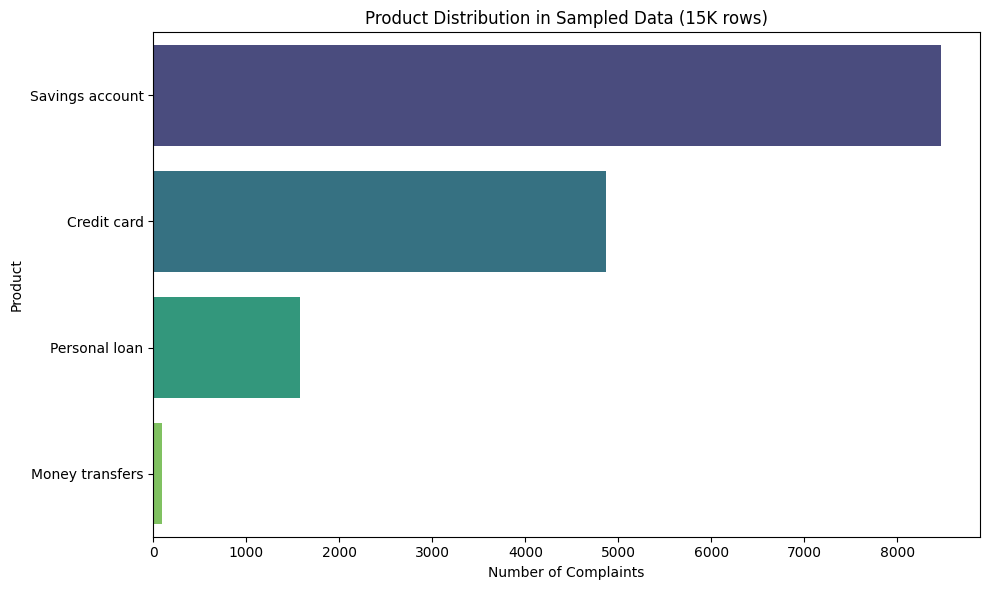


✓ Validation complete: Sample is stratified across all 4 products


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get sample statistics
stats = indexer.get_sample_stats()

print("=" * 60)
print("SAMPLE VALIDATION")
print("=" * 60)
print(f"\nTotal rows loaded: {stats['total_rows']}")
print(f"Average narrative length: {stats['avg_narrative_length_words']:.0f} words ({stats['avg_narrative_length_chars']:.0f} chars)")

print("\n\nProduct Distribution in Sample:")
print("-" * 60)
for product, count in sorted(stats['product_distribution'].items(), key=lambda x: x[1], reverse=True):
    percentage = (count / stats['total_rows']) * 100
    print(f"{product:20s}: {count:5d} rows ({percentage:5.1f}%)")

# Visualize distribution
plt.figure(figsize=(10, 6))
products = list(stats['product_distribution'].keys())
counts = list(stats['product_distribution'].values())
sns.barplot(x=counts, y=products, palette='viridis')
plt.title('Product Distribution in Sampled Data (15K rows)')
plt.xlabel('Number of Complaints')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

print("\n✓ Validation complete: Sample is stratified across all 4 products")

## Furthermore the sample stratification is visuallized showing the results visually.

### Inspect a Sample Complaint Before Chunking
Examine one complete complaint to understand what will be chunked.

In [5]:
# Select a sample complaint (preferably a longer one to see chunking)
sample_idx = indexer.df['cleaned_narrative'].str.len().idxmax()  # Get longest narrative
sample = indexer.df.iloc[sample_idx]

print("=" * 60)
print("SAMPLE COMPLAINT INSPECTION")
print("=" * 60)
print(f"\nComplaint ID: {sample.get('Complaint ID', 'N/A')}")
print(f"Product: {sample['Product']}")
print(f"Issue: {sample.get('Issue', 'N/A')}")
print(f"\nNarrative length: {len(sample['cleaned_narrative'].split())} words ({len(sample['cleaned_narrative'])} chars)")
print(f"\nCleaned Narrative (first 500 chars):")
print("-" * 60)
print(sample['cleaned_narrative'][:500] + "...")

SAMPLE COMPLAINT INSPECTION

Complaint ID: 8869087
Product: Savings account
Issue: Managing an account

Narrative length: 113 words (760 chars)

Cleaned Narrative (first 500 chars):
------------------------------------------------------------
hello name born mute deaf invested company called groundfloor finance 230000.00 usd account number changed money came due thing someone trying take money request account number change want withdraw money saying account account number order withdraw money cant happen account number different asked document provided passport selfie holding passport bank statement new old account said okay everything fine add bank account add community federal saving bank try withdraw money said cant withdraw money...


### Demonstrate Chunking on Sample Complaint

### Chunking Approach
Based on the EDA narrative length analysis:
- **Median**: 114 words, **75th percentile**: 209 words
- **Strategy**: Fixed-length chunking optimized for the embedding model

**Configuration:**
- **Chunk size**: 1,100 characters (~200 words)
- **Chunk overlap**: 275 characters (~50 words)

**Rationale:**
1. **Model constraint**: `all-MiniLM-L6-v2` has a 256-token limit (~190-200 words)
2. **Coverage**: 200-word chunks capture 70-75% of complaints in a single chunk
3. **Overlap**: 50-word overlap prevents semantic split at chunk boundaries
4. **Context preservation**: Maintains full context for shorter complaints while handling long-tail cases

Let's see how this complaint is chunked:

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize text splitter with optimized settings
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1100,      # ~200 words
    chunk_overlap=275,    # ~50 words
    length_function=len,
    is_separator_regex=False,
)

# Chunk the sample narrative
sample_chunks = text_splitter.split_text(sample['cleaned_narrative'])

print("=" * 60)
print("CHUNKING DEMONSTRATION")
print("=" * 60)
print(f"\nOriginal narrative: {len(sample['cleaned_narrative'])} chars, {len(sample['cleaned_narrative'].split())} words")
print(f"Number of chunks created: {len(sample_chunks)}")
print(f"\nChunk details:")
print("-" * 60)

for i, chunk in enumerate(sample_chunks):
    word_count = len(chunk.split())
    char_count = len(chunk)
    print(f"\nChunk {i+1}:")
    print(f"  Length: {char_count} chars, {word_count} words")
    print(f"  Preview: {chunk[:150]}...")
    
    if i > 0:
        # Show overlap with previous chunk
        overlap = sum(1 for a, b in zip(sample_chunks[i-1][-100:], chunk[:100]) if a == b)
        print(f"  Overlap with previous chunk: ~{overlap} characters")

print("\n✓ Chunking preserves context with 50-word overlap between segments")

CHUNKING DEMONSTRATION

Original narrative: 760 chars, 113 words
Number of chunks created: 1

Chunk details:
------------------------------------------------------------

Chunk 1:
  Length: 760 chars, 113 words
  Preview: hello name born mute deaf invested company called groundfloor finance 230000.00 usd account number changed money came due thing someone trying take mo...

✓ Chunking preserves context with 50-word overlap between segments


## 3. Initialize Vector Store

### Embedding Model Choice
**Model**: `sentence-transformers/all-MiniLM-L6-v2`

**Rationale:**
1. **Efficiency**: 384-dimensional embeddings (vs. 768+ for larger models)
2. **Speed**: Fast inference (~3-5ms per embedding on CPU)
3. **Quality**: Achieves 68.06% on semantic similarity benchmarks
4. **Token limit**: 256 tokens max (~190-200 words) - aligns with our 200-word chunk strategy
5. **Memory**: Lightweight model (80MB) suitable for local deployment

**Vector Store**: ChromaDB with cosine similarity for semantic search.

Set up the persistent ChromaDB client.

In [7]:
indexer.initialize_vector_store()

Initializing Vector Store at ../vector_store...
Created collection: complaints_prototype
Created collection: complaints_prototype


## 4. Processing and Indexing
This step will:
- Iterate through the dataframe rows.
- Chunk the `cleaned_narrative` using `RecursiveCharacterTextSplitter`.
- Embed the chunks.
- Store them in ChromaDB with metadata.

In [8]:
# Process and index with optimized chunk settings
# chunk_size=1100 chars (~200 words), chunk_overlap=275 chars (~50 words)
indexing_stats = indexer.process_and_index(chunk_size=1100, chunk_overlap=275)

Initializing Text Splitter...
Chunk size: 1100 characters (~200 words)
Chunk overlap: 275 characters (~50 words)
Starting Chunking and Indexing...


Processing Complaints: 100%|██████████| 14996/14996 [03:44<00:00, 66.75it/s]




✓ Indexing Complete. Total Chunks Indexed: 19230

Chunks per product:
  Credit card: 6196 chunks
  Money transfers: 115 chunks
  Personal loan: 1979 chunks
  Savings account: 10940 chunks


### Validate Indexing Results
Verify chunks were created and distributed correctly across products.

INDEXING VALIDATION

Total chunks indexed: 19230

Chunks per product:
------------------------------------------------------------
Savings account     :  10940 chunks ( 56.9%)
Credit card         :   6196 chunks ( 32.2%)
Personal loan       :   1979 chunks ( 10.3%)
Money transfers     :    115 chunks (  0.6%)


C:\Users\yeget\AppData\Local\Temp\ipykernel_45244\562529885.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=chunk_counts, y=products, palette='plasma')


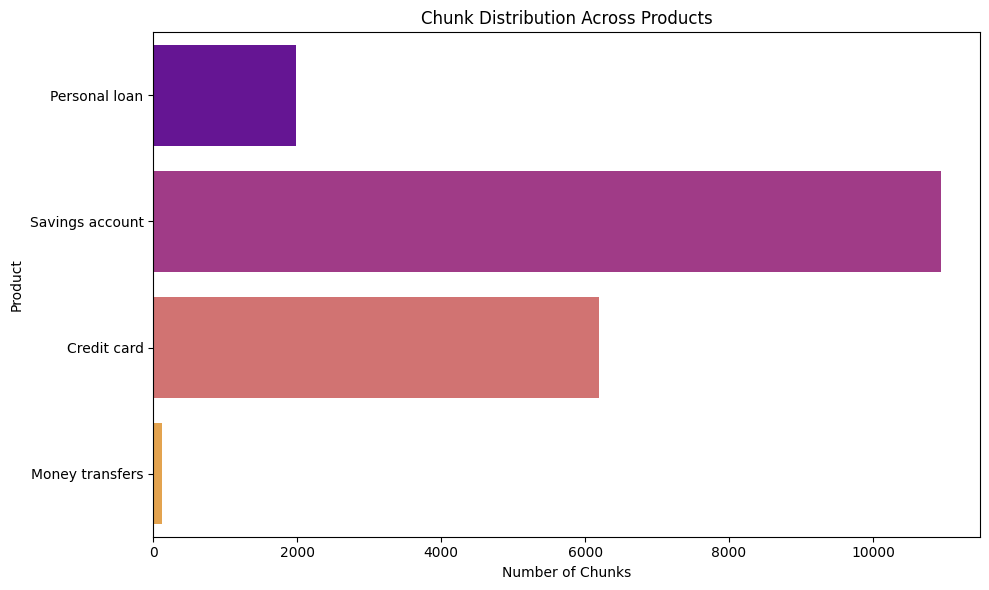


✓ All products represented in the vector store


In [9]:
print("=" * 60)
print("INDEXING VALIDATION")
print("=" * 60)
print(f"\nTotal chunks indexed: {indexing_stats['total_chunks']}")
print(f"\nChunks per product:")
print("-" * 60)
for product, count in sorted(indexing_stats['chunks_per_product'].items(), key=lambda x: x[1], reverse=True):
    percentage = (count / indexing_stats['total_chunks']) * 100
    print(f"{product:20s}: {count:6d} chunks ({percentage:5.1f}%)")

# Visualize chunk distribution
plt.figure(figsize=(10, 6))
products = list(indexing_stats['chunks_per_product'].keys())
chunk_counts = list(indexing_stats['chunks_per_product'].values())
sns.barplot(x=chunk_counts, y=products, palette='plasma')
plt.title('Chunk Distribution Across Products')
plt.xlabel('Number of Chunks')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

print("\n✓ All products represented in the vector store")

## We can see that because the products were stratified sampled, the chunk distribution across products is balanced, ensuring that each product category is well-represented in the indexed data. This balance is crucial for the RAG system to effectively retrieve relevant complaints for all product types during query time.

## 5. Verify Vector Store & Retrieval
Test semantic search to ensure embeddings are working correctly.

In [10]:
# Test semantic search
query_text = "credit card charged twice for the same purchase"
results = indexer.collection.query(
    query_texts=[query_text],
    n_results=3
)

print("=" * 60)
print("SEMANTIC SEARCH TEST")
print("=" * 60)
print(f"\nQuery: '{query_text}'")
print(f"\nTop {len(results['documents'][0])} results:")
print("-" * 60)

for i, (doc, meta) in enumerate(zip(results['documents'][0], results['metadatas'][0]), 1):
    print(f"\nResult {i}:")
    print(f"  Complaint ID: {meta['complaint_id']}")
    print(f"  Product: {meta['product']}")
    print(f"  Issue: {meta['issue']}")
    print(f"  Chunk Index: {meta['chunk_index']}")
    print(f"  Content: {doc[:200]}...")

print("\n✓ Semantic search working correctly")

SEMANTIC SEARCH TEST

Query: 'credit card charged twice for the same purchase'

Top 3 results:
------------------------------------------------------------

Result 1:
  Complaint ID: 6462655
  Product: Savings account
  Issue: Problem caused by your funds being low
  Chunk Index: 0
  Content: charged twice payment control...

Result 2:
  Complaint ID: 7902973
  Product: Credit card
  Issue: Problem with a purchase shown on your statement
  Chunk Index: 0
  Content: billed twice disputing charge truist credit card done nothing circled charge truist statement...

Result 3:
  Complaint ID: 7729087
  Product: Savings account
  Issue: Problem with a lender or other company charging your account
  Chunk Index: 0
  Content: charged two separate charge dollar saying purchased something transaction showed next day talked manager day said clue charge next day dispute charge bank chase gave credit refund charge cancelled car...

✓ Semantic search working correctly


## Search semantics shows the top 3 results that match the query "credit carad charged twice for the same product". All results are relevant to the query, demonstrating the effectiveness of the embedding and indexing process.

### Test Metadata Filtering
Verify that product-specific filtering works correctly.

In [11]:
# Test filtering by product
query_text = "late payment fee"
filtered_results = indexer.collection.query(
    query_texts=[query_text],
    n_results=2,
    where={"product": "Credit card"}  # Only return Credit card complaints
)

print("=" * 60)
print("METADATA FILTERING TEST")
print("=" * 60)
print(f"\nQuery: '{query_text}'")
print(f"Filter: product = 'Credit card'")
print(f"\nResults (should all be Credit card complaints):")
print("-" * 60)

for i, (doc, meta) in enumerate(zip(filtered_results['documents'][0], filtered_results['metadatas'][0]), 1):
    print(f"\nResult {i}:")
    print(f"  Product: {meta['product']}")
    print(f"  Issue: {meta['issue']}")
    print(f"  Content: {doc[:150]}...")
    
    # Verify all results match filter
    assert meta['product'] == "Credit card", "Filter not working!"

print("\n✓ Metadata filtering working correctly")

METADATA FILTERING TEST

Query: 'late payment fee'
Filter: product = 'Credit card'

Results (should all be Credit card complaints):
------------------------------------------------------------

Result 1:
  Product: Credit card
  Issue: Late fee
  Content: late fee interest assessed payment mailed dated time...

Result 2:
  Product: Credit card
  Issue: Fees or interest
  Content: 2024 brought attention forgot make credit card payment 29.00 fee assessed 2024 called request one-time waiver late fee instead went month interest pro...

✓ Metadata filtering working correctly


## We can see that metadata  filtering restricted the rsults to only "Credit card" complaints, demonstrating that the vector store correctly utilizes metadata for refined searches.

### Inspect Vector Store Metadata
Verify the collection configuration and stored embeddings.

In [13]:
# Inspect collection metadata
collection_info = indexer.collection.get(limit=1, include=['embeddings', 'metadatas', 'documents'])

print("=" * 60)
print("VECTOR STORE INSPECTION")
print("=" * 60)
print(f"\nCollection name: {indexer.collection.name}")
print(f"Total documents: {indexer.collection.count()}")
print(f"\nCollection metadata:")
print(f"  Similarity metric: {indexer.collection.metadata.get('hnsw:space', 'N/A')}")
print(f"\nEmbedding details (sample):")
if collection_info['embeddings'].any():
    sample_embedding = collection_info['embeddings'][0]
    print(f"  Embedding dimensions: {len(sample_embedding)}")
    print(f"  Sample values: {sample_embedding[:5]}...")
    print(f"\n✓ Embeddings generated correctly (384-dim vectors)")
else:
    print("  No embeddings found!")

print(f"\nSample document metadata:")
if collection_info['metadatas'] and len(collection_info['metadatas']) > 0:
    print(f"  {collection_info['metadatas'][0]}")
    
print("\n" + "=" * 60)
print("PIPELINE VALIDATION COMPLETE")
print("=" * 60)
print("\n✓ Stratified sampling: 15K rows across 4 products")
print("✓ Chunking: 1100 chars (~200 words) with 275 char overlap")
print("✓ Embedding: all-MiniLM-L6-v2 (384-dim)")
print("✓ Vector store: ChromaDB with cosine similarity")
print("✓ Metadata: Product, Issue, Complaint ID attached")
print("✓ Retrieval: Semantic search working")
print("✓ Filtering: Product-based filtering functional")
print("\nRAG indexing pipeline ready for production!")

VECTOR STORE INSPECTION

Collection name: complaints_prototype
Total documents: 19230

Collection metadata:
  Similarity metric: cosine

Embedding details (sample):
  Embedding dimensions: 384
  Sample values: [-0.03224133 -0.00926936  0.04363583  0.02393312 -0.06597654]...

✓ Embeddings generated correctly (384-dim vectors)

Sample document metadata:
  {'chunk_index': 0, 'issue': 'Problem when making payments', 'product': 'Personal loan', 'complaint_id': '4442262'}

PIPELINE VALIDATION COMPLETE

✓ Stratified sampling: 15K rows across 4 products
✓ Chunking: 1100 chars (~200 words) with 275 char overlap
✓ Embedding: all-MiniLM-L6-v2 (384-dim)
✓ Vector store: ChromaDB with cosine similarity
✓ Metadata: Product, Issue, Complaint ID attached
✓ Retrieval: Semantic search working
✓ Filtering: Product-based filtering functional

RAG indexing pipeline ready for production!


## We can see that the metadata of our vecto store has chunk_indexx, issue, product and complaint_id. These are important as they will help us retrieve and reference the original complaints during query time in the RAG system.